# Assigment I

## Import Libraries

In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_auc_score, roc_curve, auc, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from typing import List, Dict
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sklearn.model_selection import cross_val_score
from math import sqrt
from scipy.stats import mstats
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier,XGBRegressor
import time
import os


## Load & External Data

In [143]:
train_url = 'https://raw.githubusercontent.com/odedovadia/AdvancedMLDLCourse/main/Assignments/Assignment%20I/train.csv'
test_url = 'https://raw.githubusercontent.com/odedovadia/AdvancedMLDLCourse/main/Assignments/Assignment%20I/test.csv'
df = pd.read_csv(train_url)

## Part 1 - Exploring The Data

In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8164 entries, 0 to 8163
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    8164 non-null   object 
 1   season      8164 non-null   int64  
 2   holiday     8164 non-null   int64  
 3   workingday  8164 non-null   int64  
 4   weather     8164 non-null   int64  
 5   temp        8164 non-null   float64
 6   atemp       8164 non-null   float64
 7   humidity    8164 non-null   int64  
 8   windspeed   8164 non-null   float64
 9   pollution   8164 non-null   float64
 10  sunlight    8164 non-null   float64
 11  traffic     8164 non-null   float64
 12  count       8164 non-null   int64  
dtypes: float64(6), int64(6), object(1)
memory usage: 829.3+ KB


We can clearly see that our data doesnt have missing values, no categorial values (all converted to numbers) and one object datetime that we should convert

In [145]:
df.describe()

season      holiday   workingday      weather         temp  \
count  8164.000000  8164.000000  8164.000000  8164.000000  8164.000000   
mean      2.510289     0.029397     0.683244     1.415483    20.244980   
std       1.117178     0.168928     0.465240     0.631242     7.796018   
min       1.000000     0.000000     0.000000     1.000000     0.820000   
25%       2.000000     0.000000     0.000000     1.000000    13.940000   
50%       3.000000     0.000000     1.000000     1.000000    20.500000   
75%       4.000000     0.000000     1.000000     2.000000    26.240000   
max       4.000000     1.000000     1.000000     4.000000    41.000000   

             atemp     humidity    windspeed    pollution     sunlight  \
count  8164.000000  8164.000000  8164.000000  8164.000000  8164.000000   
mean     23.670160    61.835130    12.791334    47.152120    20.245980   
std       8.468725    19.255791     8.213914    72.882602     7.796018   
min       0.760000     0.000000     0.000000     0.000304     0.821000   
25%      16.665000    47.000000     7.001500     3.693188    13.941000   
50%      24.240000    62.000000    12.998000    17.684113    20.501000   
75%      31.060000    77.000000    16.997900    59.257746    26.241000   
max      45.455000   100.000000    56.996900   754.304876    41.001000   

           traffic        count  
count  8164.000000  8164.000000  
mean      0.004986   191.339784  
std       0.006319   181.143178  
min       0.000000     1.000000  
25%       0.000000    41.000000  
50%       0.000242   145.000000  
75%       0.004489   285.000000  
max       0.015615   970.000000

## 1. Visualizations

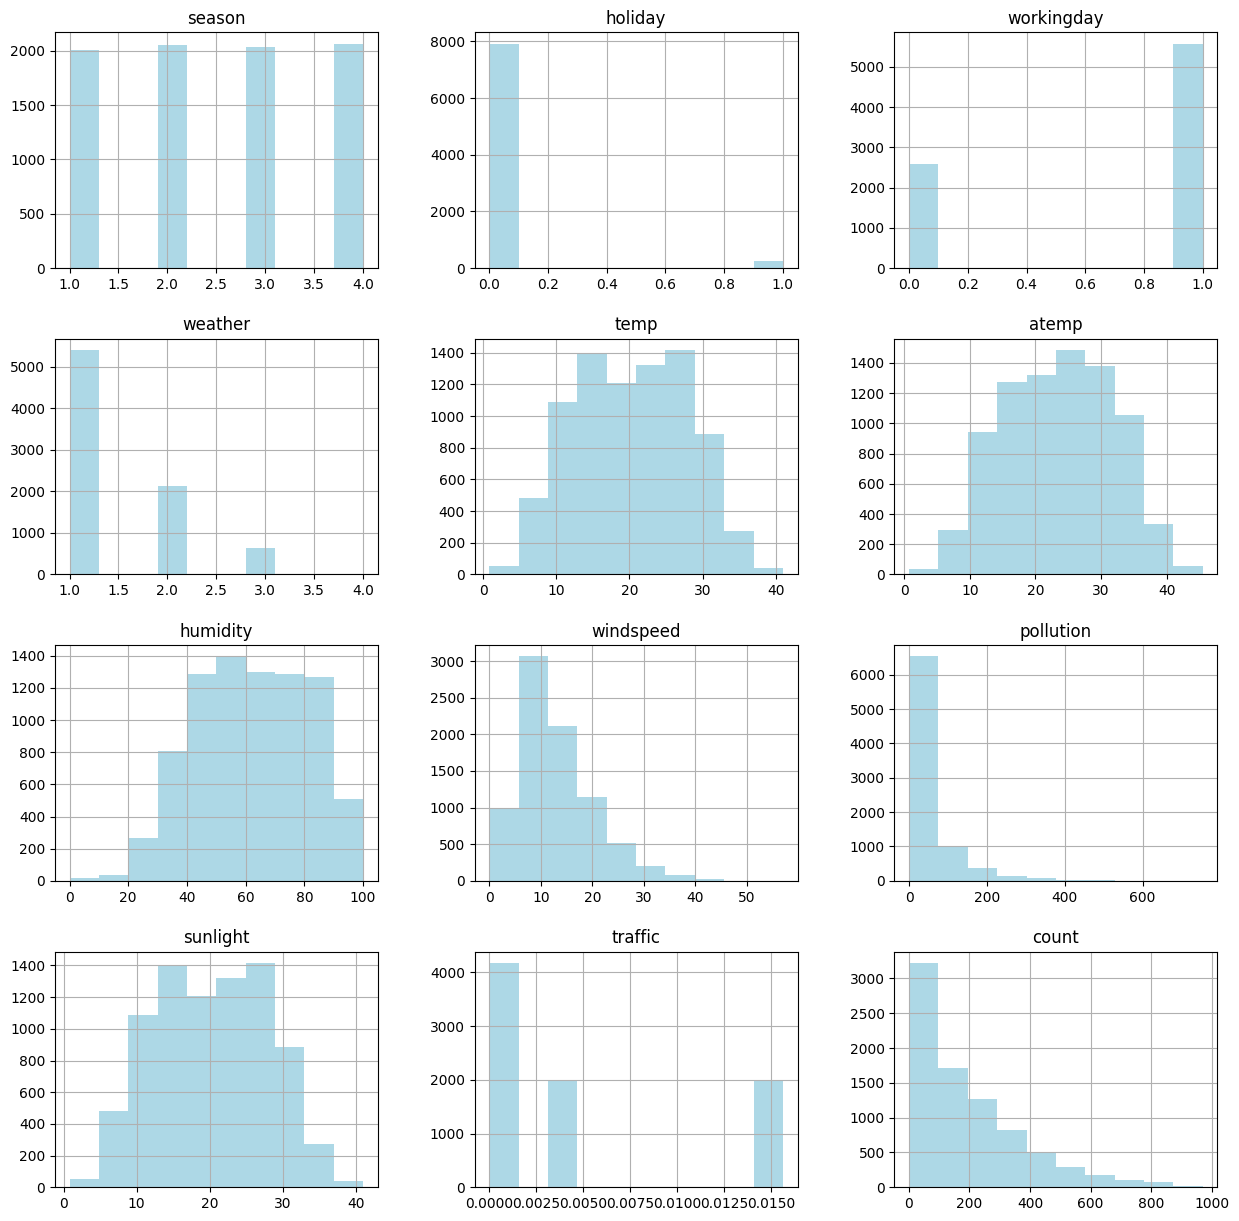

In [146]:
def plot_distribution (data, color):
    """
    input: the train data and a color
    output: plots the feature distribution
    """
    pd.concat([data],axis=1).hist(figsize=(15,15), color  = color)
    plt.show()

plot_distribution(df, 'lightblue')

Now lets break down the date and time into different components in order to analyze trends/seasonal patterns and more of that.

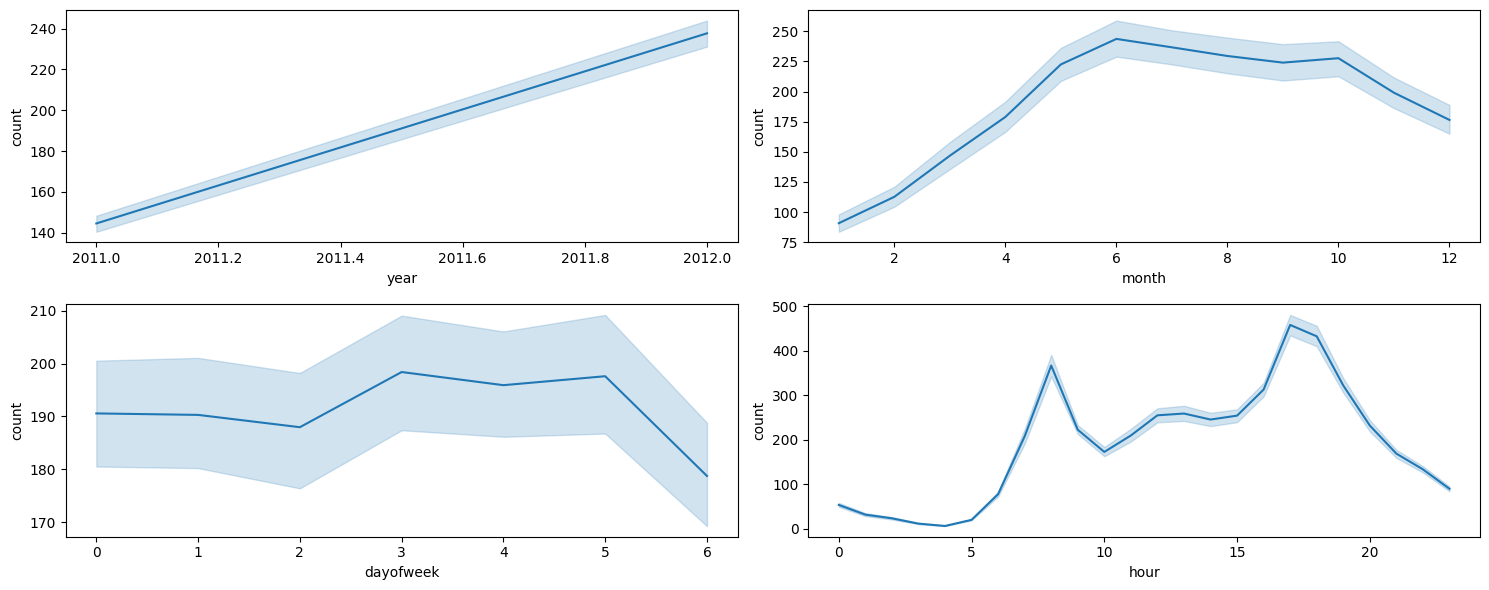

In [147]:
df['datetime'] = pd.to_datetime(df['datetime'])
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['dayofweek'] = df['datetime'].dt.dayofweek

# Plotting trends over time
plt.figure(figsize=(15, 6))
plt.subplot(2, 2, 1)
sns.lineplot(x='year', y='count', data=df)
plt.subplot(2, 2, 2)
sns.lineplot(x='month', y='count', data=df)
plt.subplot(2, 2, 3)
sns.lineplot(x='dayofweek', y='count', data=df)
plt.subplot(2, 2, 4)
sns.lineplot(x='hour', y='count', data=df)
plt.tight_layout()
plt.show()


In [148]:
def move_columns_to_front(data, columns_to_move):
    """
    Moves specified columns to the beginning of the DataFrame.

    Parameters:
    data (DataFrame): The DataFrame to be modified.
    columns_to_move (list): A list of column names to be moved to the front.

    Returns:
    DataFrame: A DataFrame with specified columns moved to the front.
    """
    # Ensure all columns to move are in the DataFrame
    columns_to_move = [col for col in columns_to_move if col in data.columns]

    # Get the remaining columns and avoid duplication
    remaining_columns = [col for col in data.columns if col not in columns_to_move]

    # Concatenate lists to get new column order
    new_column_order = columns_to_move + remaining_columns

    # Reorder DataFrame
    return data[new_column_order]



new_columns = ['year', 'month', 'day', 'hour', 'dayofweek']
df = move_columns_to_front(df, new_columns)

Now lets check in different weathers the bike rental count

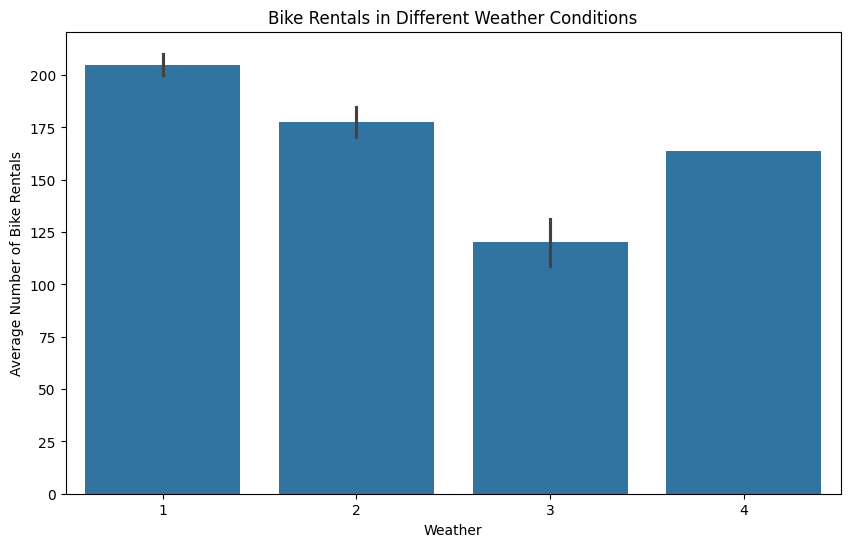

In [149]:
plt.figure(figsize=(10, 6))
sns.barplot(x='weather', y='count', data=df)
plt.title('Bike Rentals in Different Weather Conditions')
plt.xlabel('Weather')
plt.ylabel('Average Number of Bike Rentals')
plt.show()

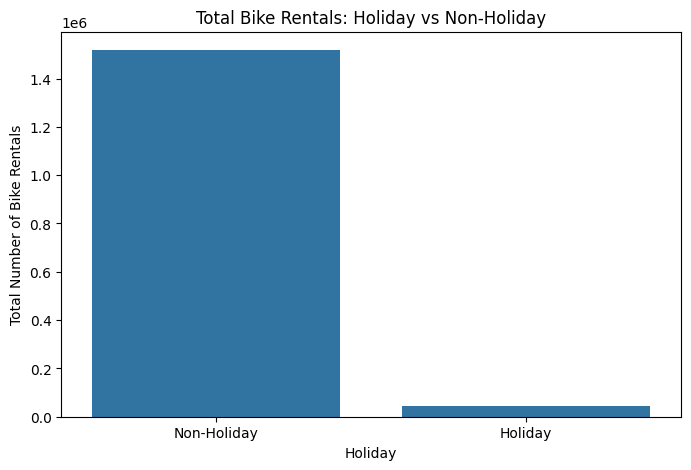

holiday
0    1517865
1      44233
Name: count, dtype: int64


In [150]:
def plot_total_holiday_rental_counts(df, holiday_col='holiday', count_col='count'):
    """
    Plots the total bike rental counts for holidays vs non-holidays.

    :param df: DataFrame containing the bike rental data.
    :param holiday_col: Name of the column indicating holidays.
    :param count_col: Name of the column indicating the count of bike rentals.
    """
    total_counts = df.groupby(holiday_col)[count_col].sum().reset_index()

    plt.figure(figsize=(8, 5))
    sns.barplot(x=holiday_col, y=count_col, data=total_counts)
    plt.title('Total Bike Rentals: Holiday vs Non-Holiday')
    plt.xlabel('Holiday')
    plt.ylabel('Total Number of Bike Rentals')
    plt.xticks([0, 1], ['Non-Holiday', 'Holiday'])
    plt.show()

plot_total_holiday_rental_counts(df)
total_rentals_by_holiday = df.groupby('holiday')['count'].sum()
print(total_rentals_by_holiday)

since there are more non holiday days in the year than holiday it does not make sense to take the count so lets try and see the average per day for each one

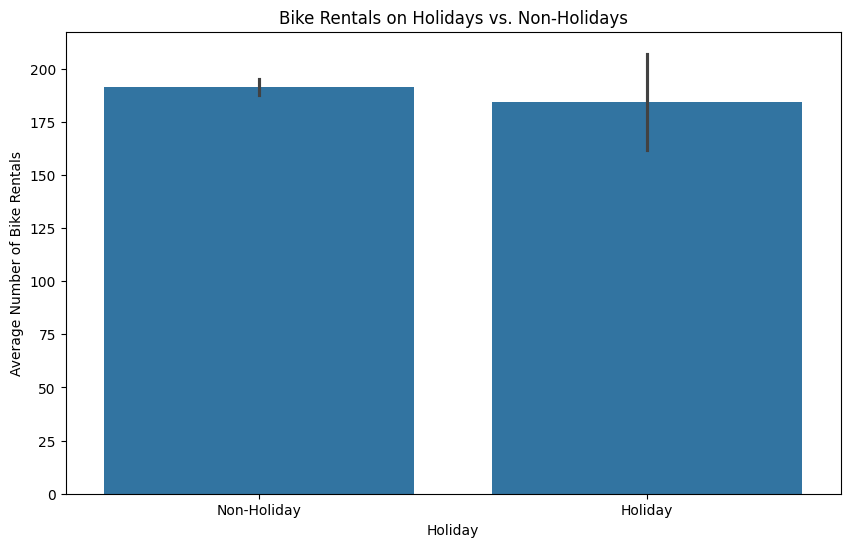

In [151]:
plt.figure(figsize=(10, 6))
sns.barplot(x='holiday', y='count', data=df)
plt.title('Bike Rentals on Holidays vs. Non-Holidays')
plt.xlabel('Holiday')
plt.xticks([0, 1], ['Non-Holiday', 'Holiday'])
plt.ylabel('Average Number of Bike Rentals')
plt.show()

## 2. Feature Correlation


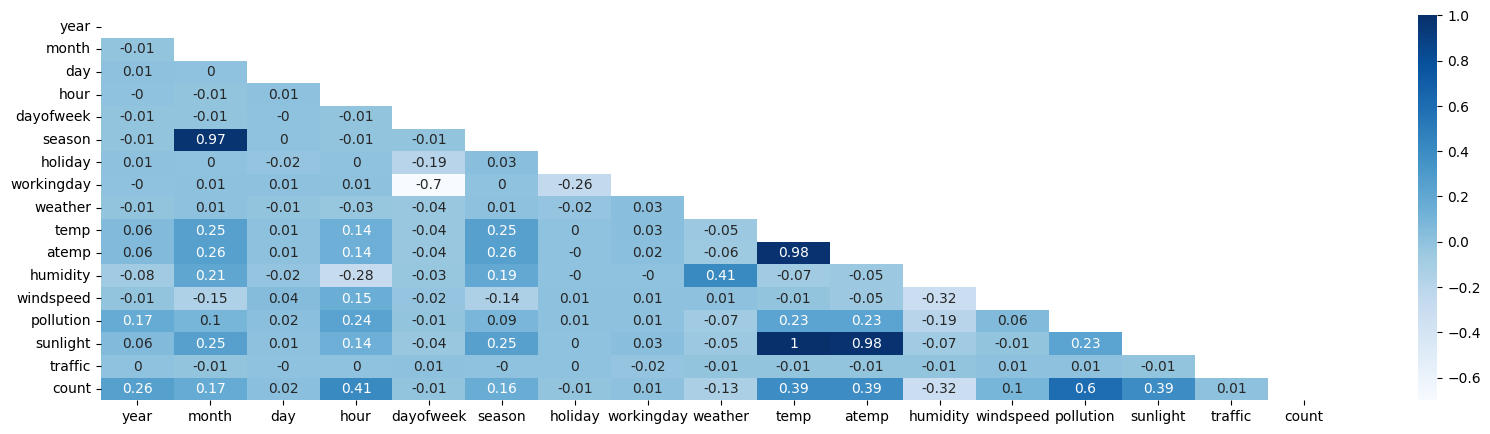

In [152]:
def visualize_correlation_matrix(data):
    """
    Visualizes the correlation matrix of the DataFrame using a heatmap.

    Parameters:
    data (DataFrame): The DataFrame for which the correlation matrix is to be visualized.

    Returns:
    None: Displays a heatmap of the correlation matrix.
    """
    # Calculate the correlation matrix
    corr_mat = data.corr().round(2)

    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_mat, dtype=bool))

    # Setting up the matplotlib figure
    plt.figure(figsize=(20, 5))

    # Draw the heatmap with the mask
    sns.heatmap(corr_mat, mask=mask, xticklabels=corr_mat.columns, yticklabels=corr_mat.columns, annot=True, cmap='Blues')

    # Display the plot
    plt.show()

visualize_correlation_matrix(df)

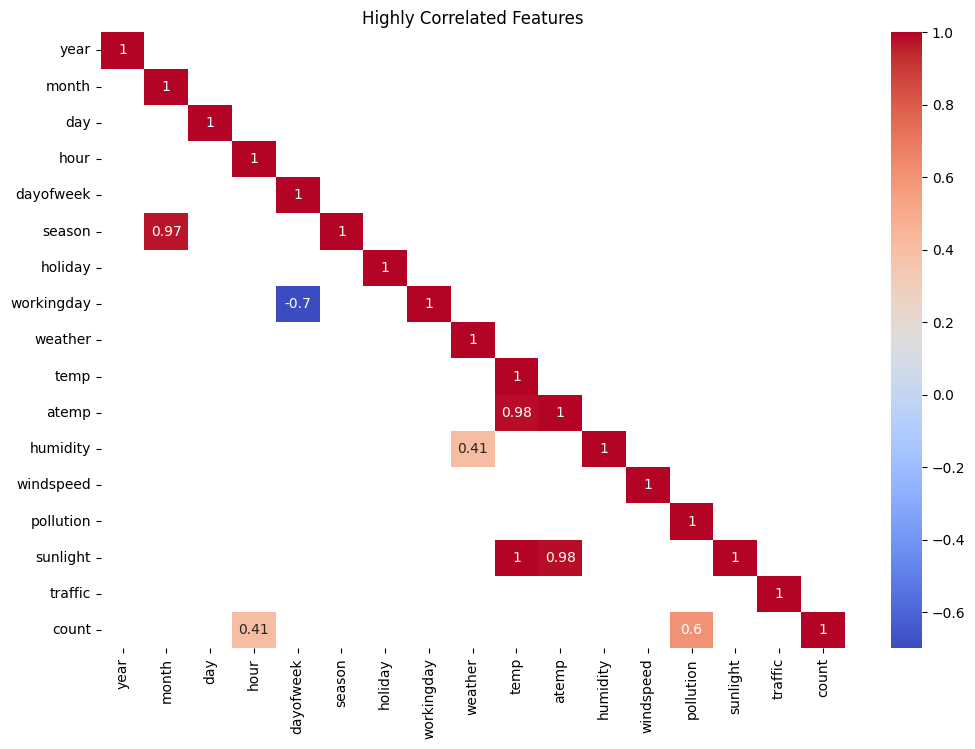

In [153]:

# Calculate the correlation matrix
corr_matrix = df.corr()

# Set a threshold to identify highly correlated features (e.g., above 0.5 or below -0.5)
threshold = 0.4

# Filter the correlation matrix
high_corr = corr_matrix[(corr_matrix >= threshold) | (corr_matrix <= -threshold)]

# Mask to hide the upper triangle of the symmetric correlation matrix
mask = pd.DataFrame(high_corr).isnull()
for i in range(mask.shape[0]):
    mask.iloc[i, i+1:] = True

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(high_corr, annot=True, cmap='coolwarm', mask=mask)
plt.title('Highly Correlated Features')
plt.show()


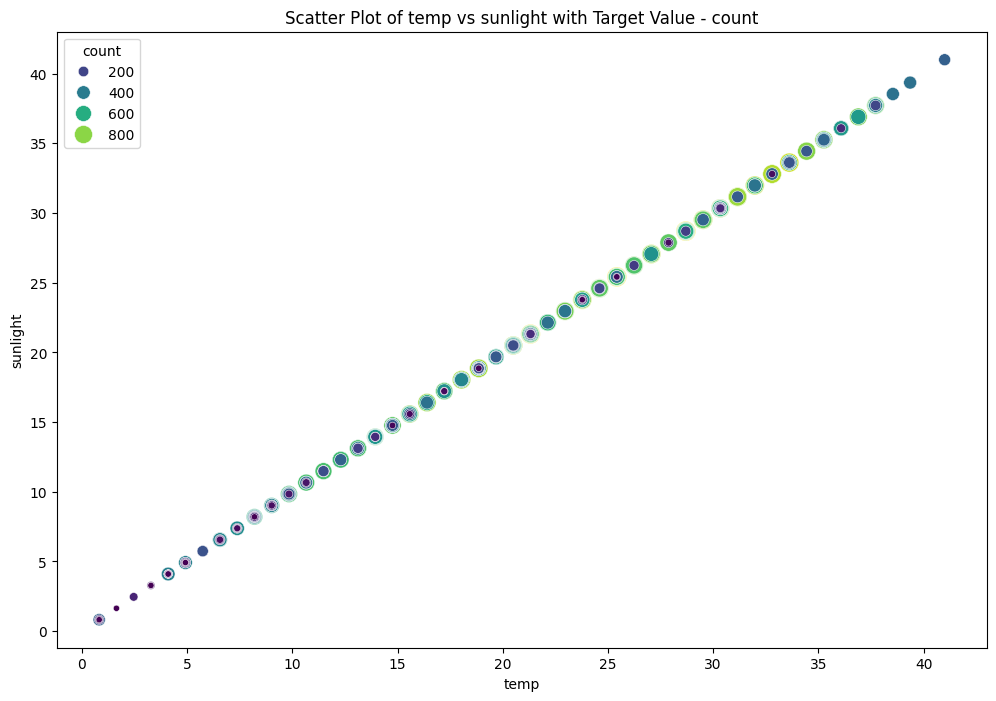

In [154]:
sns.scatterplot(x='temp', y='sunlight', data=df, hue='count', palette='viridis', size='count', sizes=(20, 200))
plt.title('Scatter Plot of temp vs sunlight with Target Value - count')
plt.show()

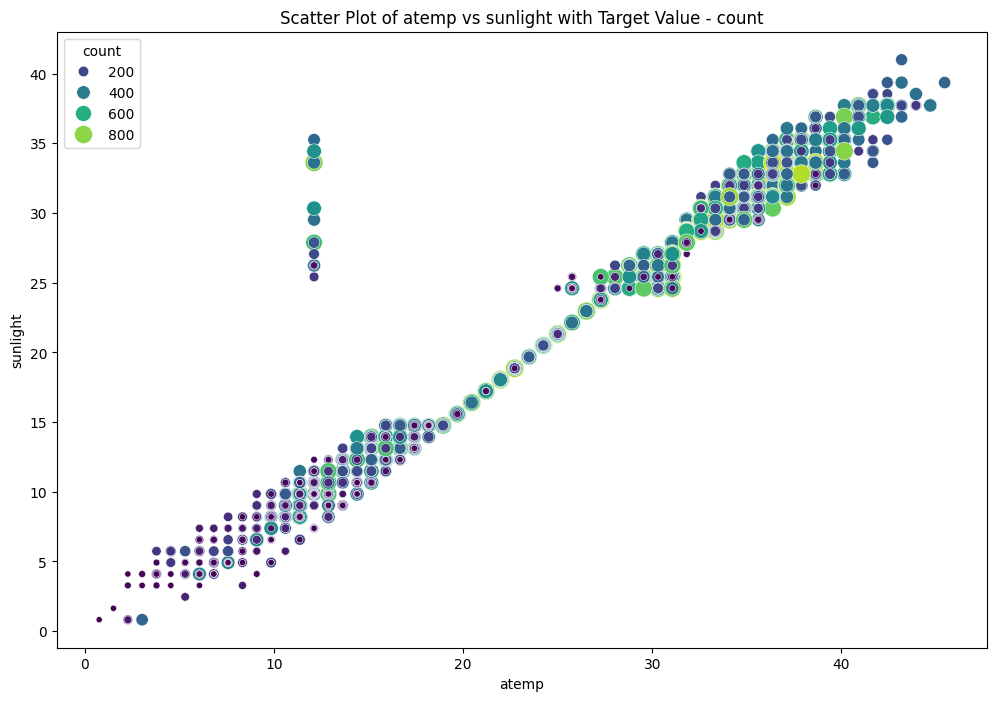

In [155]:
sns.scatterplot(x='atemp', y='sunlight', data=df, hue='count', palette='viridis', size='count', sizes=(20, 200))
plt.title('Scatter Plot of atemp vs sunlight with Target Value - count')
plt.show()

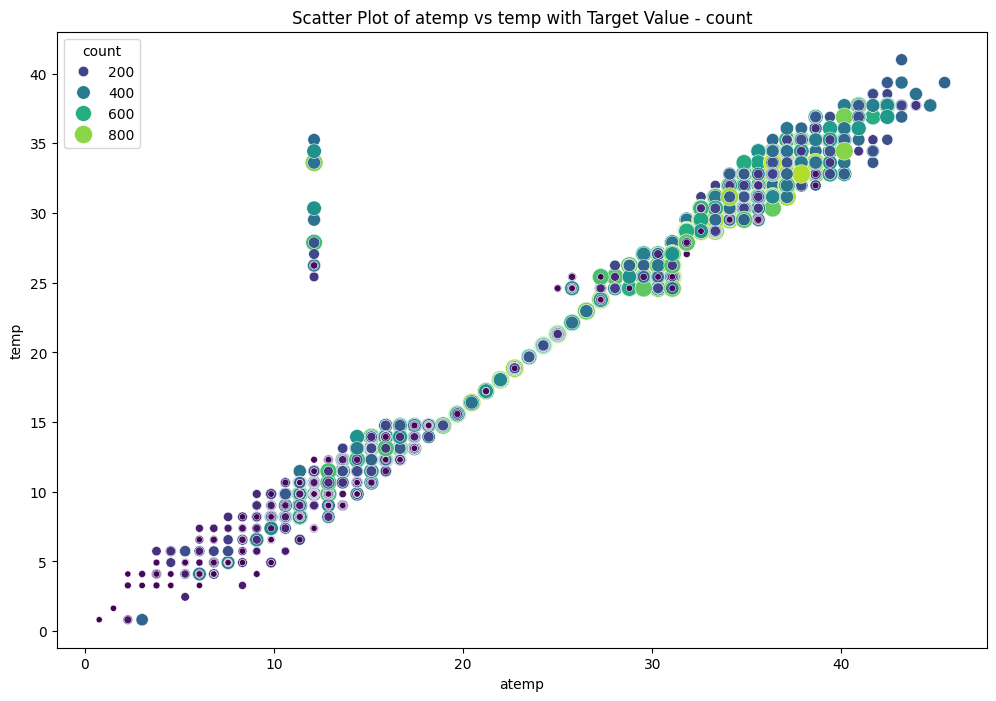

In [156]:
sns.scatterplot(x='atemp', y='temp', data=df, hue='count', palette='viridis', size='count', sizes=(20, 200))
plt.title('Scatter Plot of atemp vs temp with Target Value - count')
plt.show()

We can see that the graph is very simillar to the correlation plot between "atemp" and "sunlight". It is not surprising due to the strong correlation between "temp" and "sunlight". The same outlier that distrupted in the correlation between "atemp" and "sunlight" appears also here.

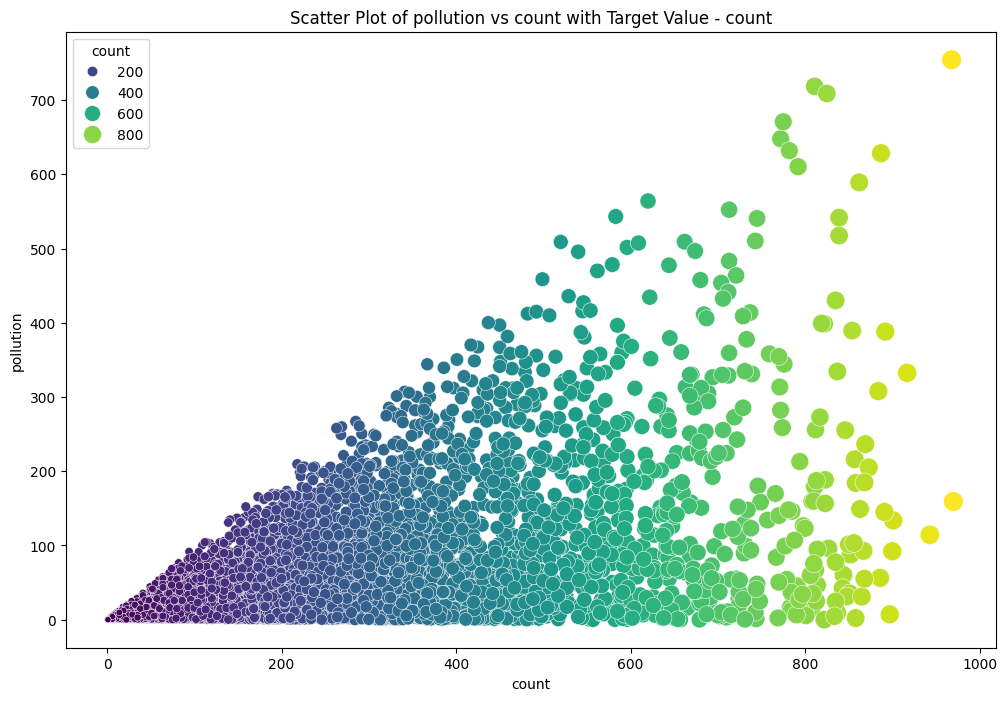

In [157]:
sns.scatterplot(x='count', y='pollution', data=df, hue='count', palette='viridis', size='count', sizes=(20, 200))
plt.title('Scatter Plot of pollution vs count with Target Value - count')
plt.show()


The graph suggests a correlation where higher bike rental counts are associated with increased pollution levels, which is a logical observation.

The correlation heatmap and the graphs indicates that it would be prudent to eliminate the features 'sunlight' and 'temp'. This is due to 'sunlight' and 'temp' having a correlation of 1, and 'temp' and 'atemp' having a correlation of 0.98. Additionally, the feature 'traffic' will be removed owing to its minimal correlation with the target feature. These measures are undertaken with the objective of reducing dimensionality.

### colleration with the target


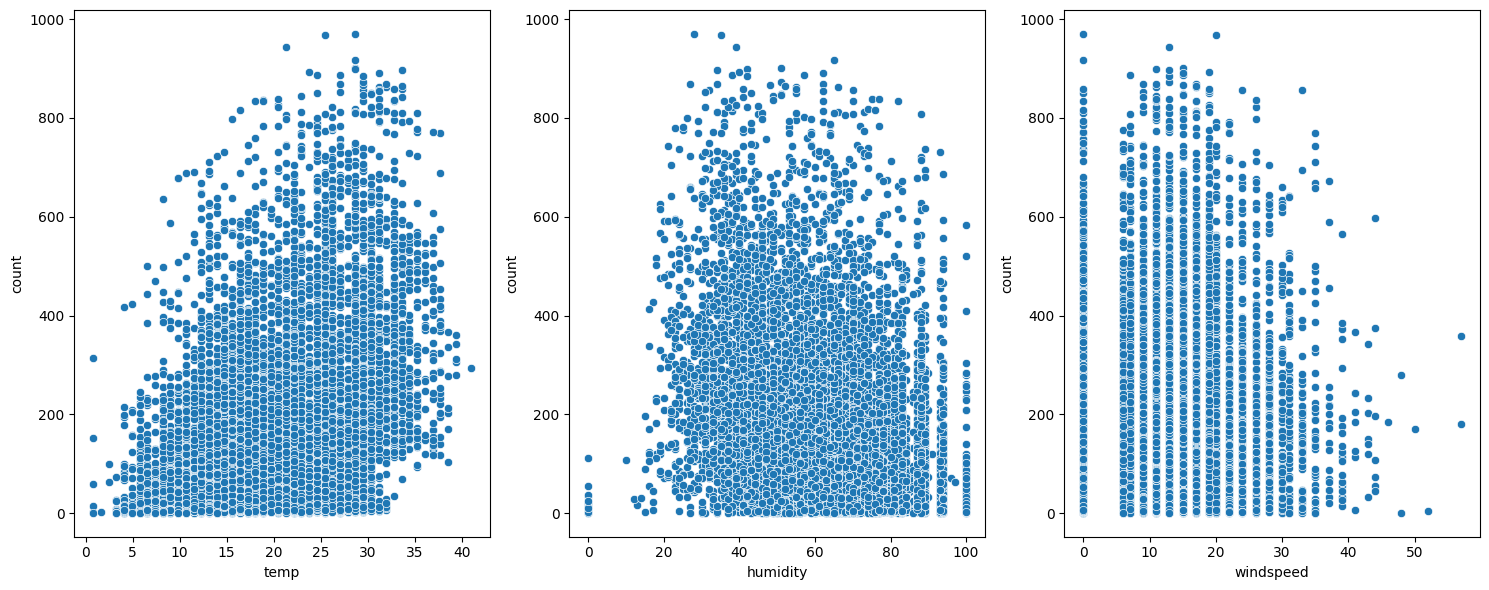

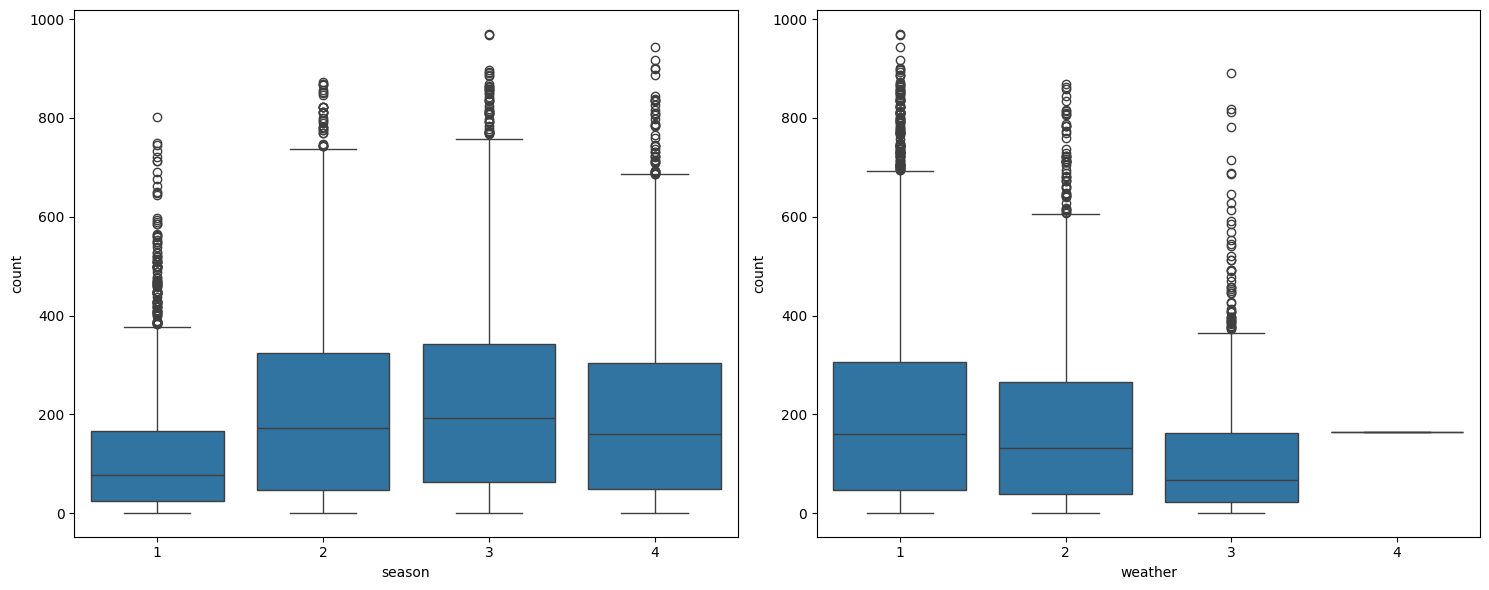

In [158]:
# Scatter plot for continuous variables
plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
sns.scatterplot(x='temp', y='count', data=df)
plt.subplot(1, 3, 2)
sns.scatterplot(x='humidity', y='count', data=df)
plt.subplot(1, 3, 3)
sns.scatterplot(x='windspeed', y='count', data=df)
plt.tight_layout()
plt.show()

# Box plots for categorical variables
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='season', y='count', data=df)
plt.subplot(1, 2, 2)
sns.boxplot(x='weather', y='count', data=df)
plt.tight_layout()
plt.show()


#### These scatter plots does not show any clear/linear relationship and maybe its infulenced by other factors,we will try creating new feature-Comfortable weather that might capture combined effects or specific condtions that can be helpful

in the season and weather wee see that the boxplots are normal and we should just consider removing the outliers (weather number 4 got 1 sample and we should take care of that too)



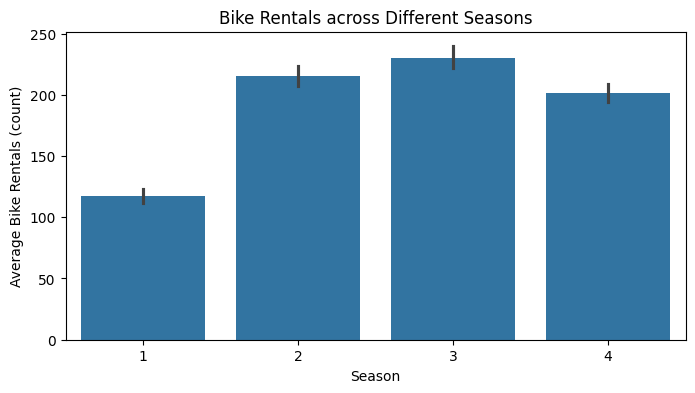

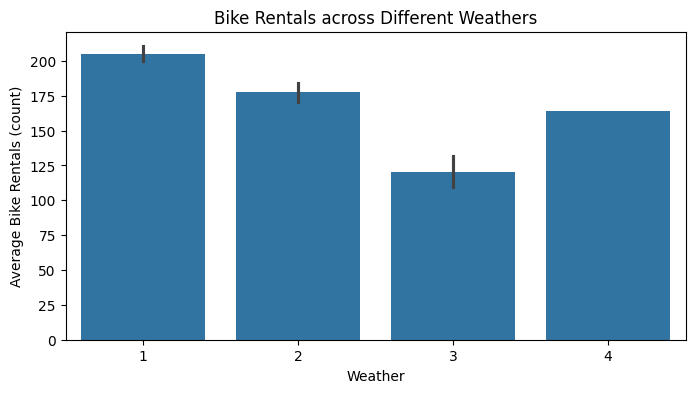

In [159]:

categorical_features = ['season', 'weather']

for feature in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.barplot(x=df[feature], y=df['count'])
    plt.title(f'Bike Rentals across Different {feature.capitalize()}s')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Average Bike Rentals (count)')
    plt.show()


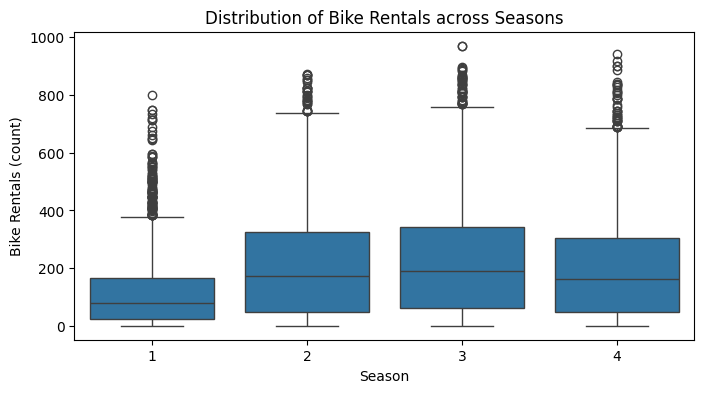

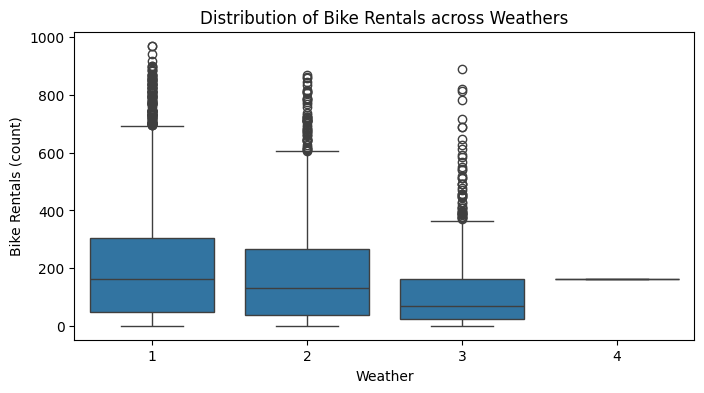

In [160]:
for feature in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[feature], y=df['count'])
    plt.title(f'Distribution of Bike Rentals across {feature.capitalize()}s')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Bike Rentals (count)')
    plt.show()


In [161]:
print(df[df['weather'] == 4].shape[0])
print(df[df['weather'] == 4]['count'])

 #we have only one sample of weather 4 and it got count of 164 bike rentals

1
6484    164
Name: count, dtype: int64


## Part 2- Pre Preproccing


**After Analyzing all the components of weather Now lets create comfortable weather feature- moderate temprature and low humidity and windspeed, weather-1 clear partly cloudy,with normal sunlight**

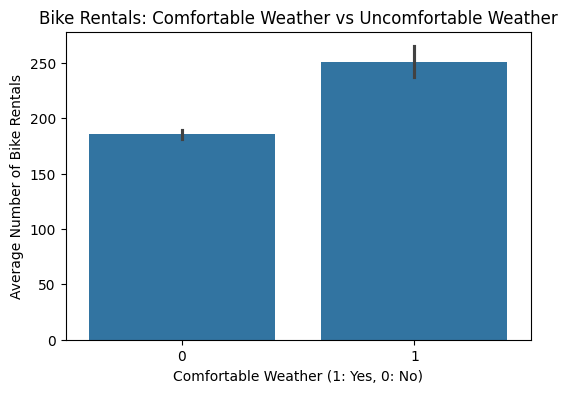

In [162]:
temp_comfortable_low, temp_comfortable_high = df['temp'].quantile([0.25, 0.75])
humidity_comfortable = df['humidity'].quantile(0.60)  # Below 60th percentile
windspeed_comfortable = df['windspeed'].quantile(0.60)  # Below 60th percentile
sunlight_comfortable = df['sunlight'].quantile(0.40)  # Above 40th percentile, if sunlight is a measure of brightness

df['comfortable_weather'] = ((df['weather'] == 1) &
                             (df['temp'] >= temp_comfortable_low) &
                             (df['temp'] <= temp_comfortable_high) &
                             (df['humidity'] <= humidity_comfortable) &
                             (df['windspeed'] <= windspeed_comfortable) &
                             (df['sunlight'] >= sunlight_comfortable)).astype(int)

plt.figure(figsize=(6, 4))
sns.barplot(x='comfortable_weather', y='count', data=df)
plt.title('Bike Rentals: Comfortable Weather vs Uncomfortable Weather')
plt.xlabel('Comfortable Weather (1: Yes, 0: No)')
plt.ylabel('Average Number of Bike Rentals')
plt.show()



In [163]:

# making new features that are specific for each time type
df['datetime'] = pd.to_datetime(df['datetime'])
df['hour'] = df['datetime'].dt.hour
df['dayofweek'] = df['datetime'].dt.dayofweek
df['month'] = df['datetime'].dt.month


We drop temp,sunlight because they are highly correlated =1 and keeping averagetem(atemp feature) along with that we drop traffic feature since it got 0 affect on all other features as we can see in the correlation matrix


In [164]:
df = df.drop(['temp','sunlight','traffic'], axis=1)
df

year  month  day  hour  dayofweek            datetime  season  holiday  \
0     2011      7   11     0          0 2011-07-11 00:00:00       3        0   
1     2012      5   18    22          4 2012-05-18 22:00:00       2        0   
2     2011      4    1    23          4 2011-04-01 23:00:00       2        0   
3     2012      9   16     9          6 2012-09-16 09:00:00       3        0   
4     2011      2    1    23          1 2011-02-01 23:00:00       1        0   
...    ...    ...  ...   ...        ...                 ...     ...      ...   
8159  2012      1   14     2          5 2012-01-14 02:00:00       1        0   
8160  2011     12   10     9          5 2011-12-10 09:00:00       4        0   
8161  2011     12   18    16          6 2011-12-18 16:00:00       4        0   
8162  2011      2   19     7          5 2011-02-19 07:00:00       1        0   
8163  2012      5    2     7          2 2012-05-02 07:00:00       2        0   

      workingday  weather   atemp  humidity  windspeed  pollution  count  \
0              1        1  32.575        65    12.9980   5.354100     35   
1              1        1  26.515        52    22.0028  85.425233    251   
2              1        1  15.910        61     6.0032   2.040899     53   
3              0        1  27.275        60     8.9981  26.682772    296   
4              1        3   9.850        93    12.9980   5.851754     16   
...          ...      ...     ...       ...        ...        ...    ...   
8159           0        1   8.335        47    11.0014  14.953355     38   
8160           0        1  12.880        61    19.0012   7.977025    149   
8161           0        1  13.635        48    16.9979   6.916512    234   
8162           0        1  19.695        17    35.0008   0.095445     22   
8163           1        2  25.760        88    12.9980  81.965417    358   

      comfortable_weather  
0                       0  
1                       0  
2                       0  
3                       1  
4                       0  
...                   ...  
8159                    0  
8160                    0  
8161                    0  
8162                    0  
8163                    0  

[8164 rows x 16 columns]

### Outliers

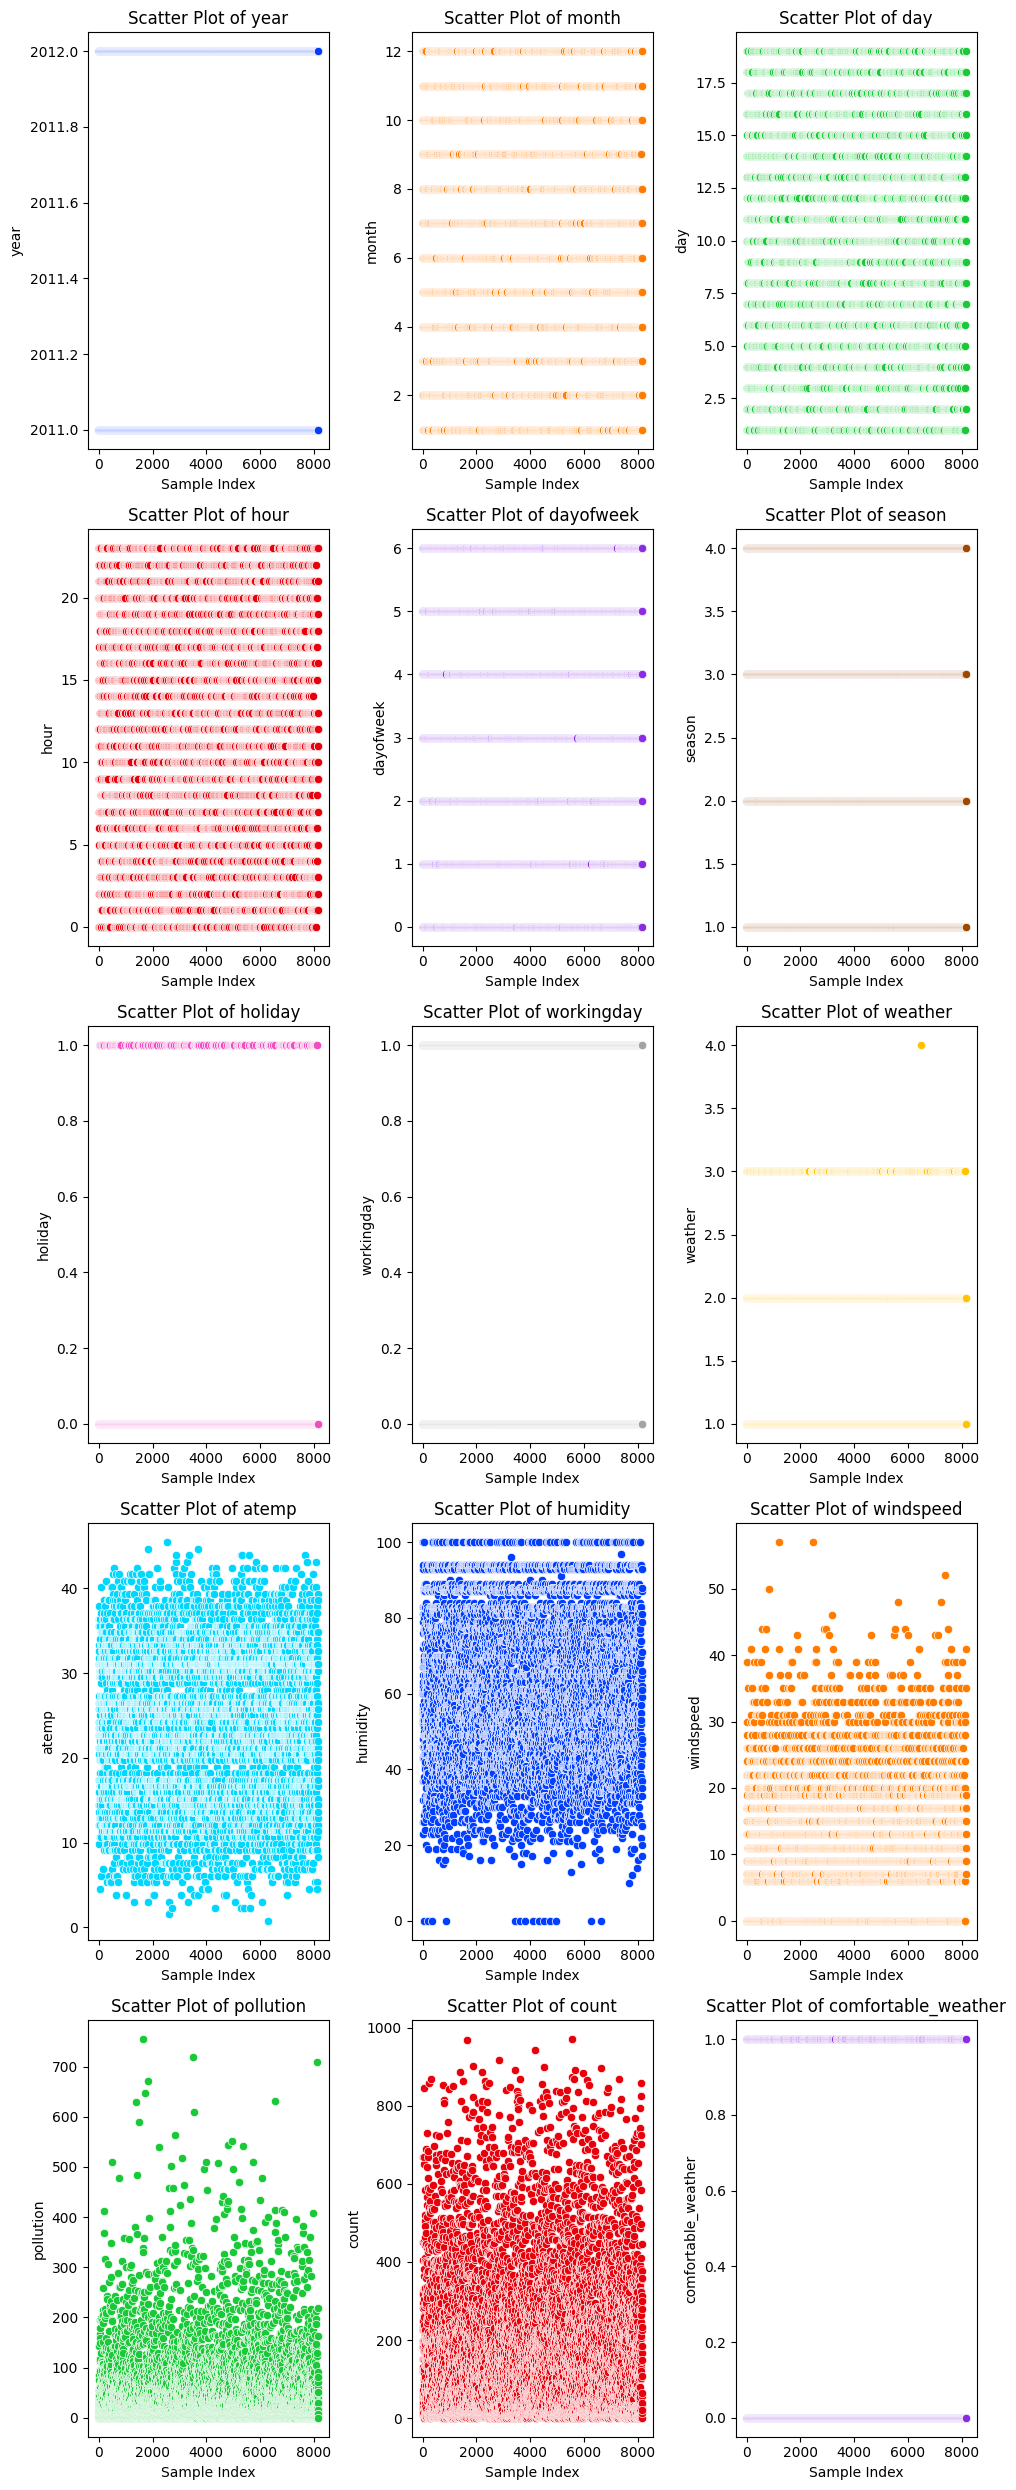

In [165]:
def visualize_outliers_scatter(data):
    """
    Visualizes potential outliers using scatter plots for each numerical feature in the data.

    Parameters:
    data (DataFrame): The dataset to be visualized.

    Returns:
    None: Displays scatter plots of the numerical features.
    """
    # Automatically select numerical features
    numeric_features = data.select_dtypes(include=[int, float]).columns

    num_features = len(numeric_features)
    num_cols = 3
    num_rows = (num_features + num_cols - 1) // num_cols

    # Create the subplot grid
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 5 * num_rows))
    axes = axes.flatten()

    # Use a default color palette
    colors = sns.color_palette('bright', n_colors=num_features)

    # Plotting scatter plots for each feature
    for i, feature in enumerate(numeric_features):
        ax = axes[i]
        sns.scatterplot(x=np.arange(len(data)), y=data[feature], ax=ax, color=colors[i])
        ax.set_title(f'Scatter Plot of {feature}')
        ax.set_xlabel('Sample Index')
        ax.set_ylabel(feature)

    # Hide any unused axes
    for i in range(num_features, len(axes)):
        axes[i].set_visible(False)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

visualize_outliers_scatter(df)

The remove_outliers function will be exclusively applied to the 'season' and 'weather' features on a per-category basis, while the winsorize_data function will be utilized for other features demonstrating the presence of outliers.

In [166]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]


def winsorize_data(df, column, lower_percentile=0.10, upper_percentile=0.9):
    """
    Apply winsorization to a specified column of a DataFrame.
    It replaces the extreme values with specified percentile values.

    :param df: pandas DataFrame
    :param column: the name of the column to winsorize
    :param lower_percentile: the lower percentile value to use for winsorization
    :param upper_percentile: the upper percentile value to use for winsorization
    :return: DataFrame with the specified column winsorized
    """
    df[column] = winsorize(df[column], limits=[lower_percentile, 1 - upper_percentile])
    return df


In [167]:
cleaned_df = pd.DataFrame()


for category in df['weather'].unique():
    category_df = df[df['weather'] == category]
    category_df_cleaned = remove_outliers(category_df, 'count')
    cleaned_df = pd.concat([cleaned_df, category_df_cleaned])

for category in df['season'].unique():
    category_df = df[df['season'] == category]
    category_df_cleaned = remove_outliers(category_df, 'count')
    cleaned_df = pd.concat([cleaned_df, category_df_cleaned])


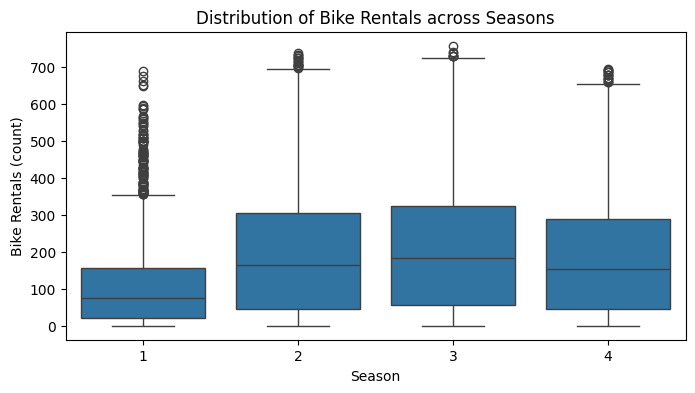

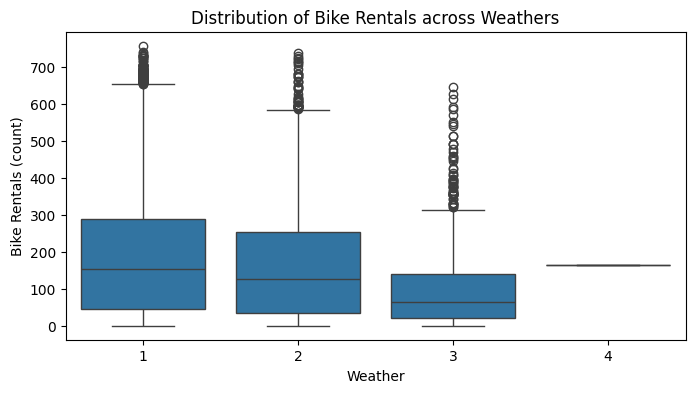

In [168]:
for feature in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=cleaned_df[feature], y=cleaned_df['count'])
    plt.title(f'Distribution of Bike Rentals across {feature.capitalize()}s')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Bike Rentals (count)')
    plt.show()



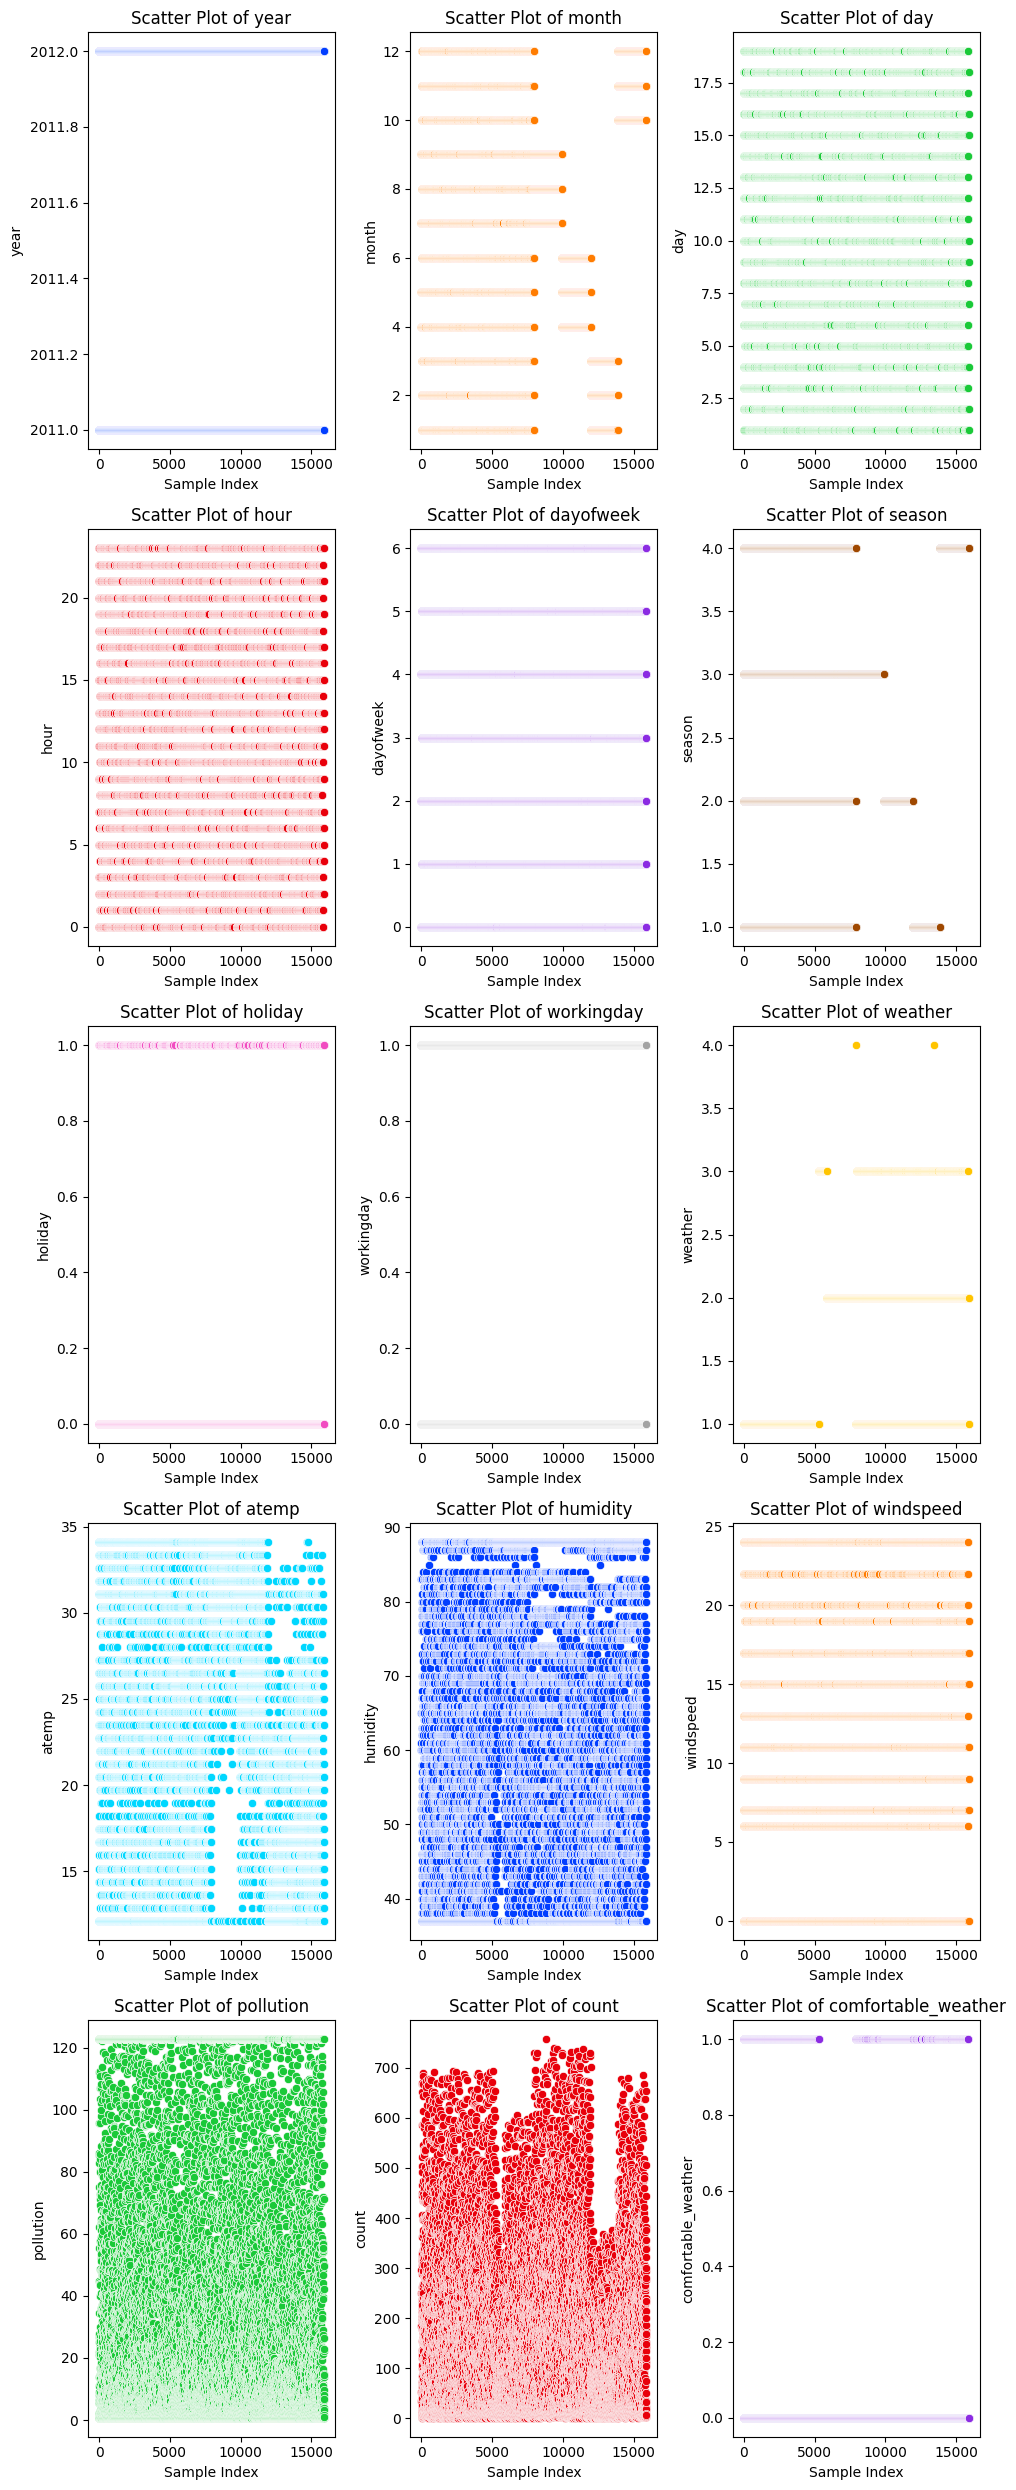

In [169]:
columns = ['atemp', 'humidity','windspeed','pollution']
for column in columns:
    cleaned_df = winsorize_data(cleaned_df, column, lower_percentile=0.10, upper_percentile=0.9)

visualize_outliers_scatter(cleaned_df)


## Part 3- Modeling

In [194]:
X = cleaned_df.drop(['count','datetime'], axis=1)
y = cleaned_df['count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Random Forest

In [171]:
# Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Train the model
rf.fit(X_train, y_train)
# Make predictions
y_pred = rf.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 762.7880159005038
Mean Absolute Error: 14.702748740554155
R^2 Score: 0.9703772627647843


### Hyperparameter tuning
### Will comment every hyperparameter tuning after finishing for the sake of reducing time

In [172]:

# # Define the parameter grid
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_features': ['auto', 'sqrt'],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Initialize the grid search
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

# # Best parameters
# print(grid_search.best_params_)

# best_rf = RandomForestRegressor(**grid_search.best_params_, random_state=42)
# best_rf.fit(X_train, y_train)

best_rf = RandomForestRegressor( max_features= 'auto', min_samples_leaf= 1, min_samples_split= 2, n_estimators= 300, random_state=42)
best_rf.fit(X_train, y_train)
# Evaluate the best model
y_pred_best = best_rf.predict(X_test)
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred_best)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred_best)}")
print(f"R^2 Score: {r2_score(y_test, y_pred_best)}")



Mean Squared Error: 742.6557480233697
Mean Absolute Error: 14.592035054575986
R^2 Score: 0.9711590958151755


### Feature Importance

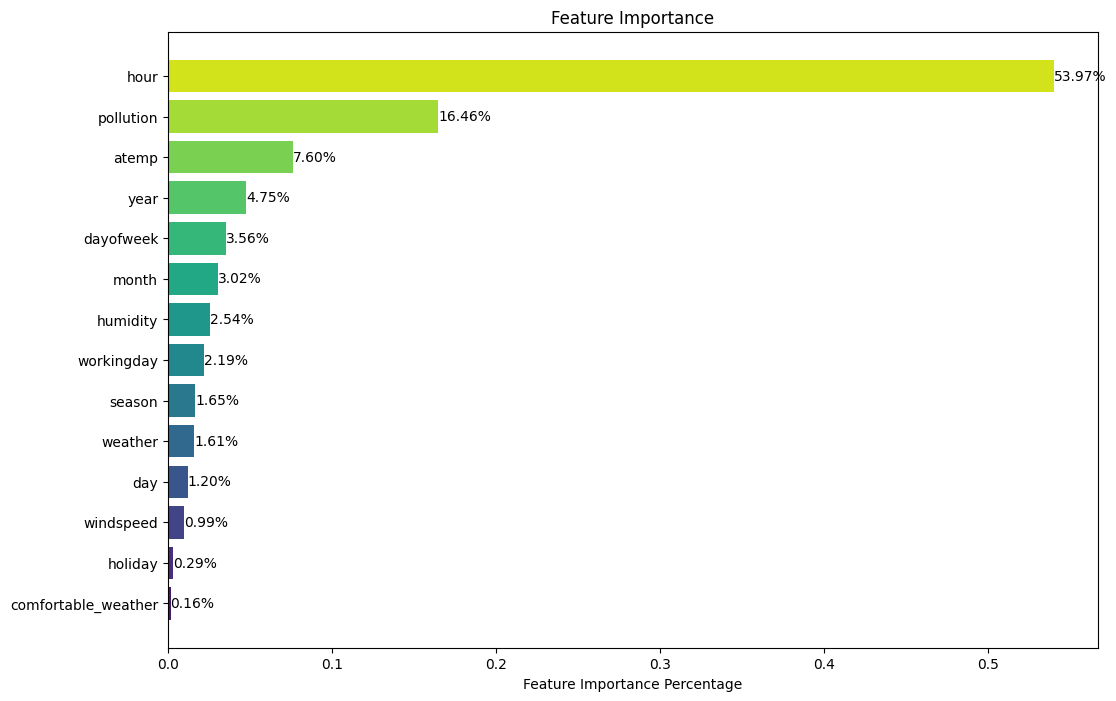

In [173]:
importances = best_rf.feature_importances_
feature_names = X.columns

# Sort the feature importances and corresponding feature names
sorted_indices = np.argsort(importances)
sorted_feature_importances = importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Set the figure size
plt.rcParams["figure.figsize"] = (12, 8)

# Create horizontal bar plot
bars = plt.barh(range(len(sorted_feature_importances)), sorted_feature_importances, align='center', color=sns.color_palette("viridis", len(sorted_feature_importances)))

# Adding percentage labels to each bar
for bar, importance in zip(bars, sorted_feature_importances):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{importance*100:.2f}%', ha='left', va='center')

plt.yticks(range(len(sorted_feature_importances)), sorted_feature_names)
plt.title('Feature Importance')
plt.xlabel('Feature Importance Percentage')
plt.show()

Now Lets try some feature engineering in order to raise more the quality of our model

In [174]:

# Hour - Sine and Cosine Transformation
cleaned_df['hour_sin'] = np.sin(cleaned_df['hour'] * (2. * np.pi / 24))
cleaned_df['hour_cos'] = np.cos(cleaned_df['hour'] * (2. * np.pi / 24))

# Pollution - Logarithmic Transformation
cleaned_df['pollution_log'] = np.log(cleaned_df['pollution'] + 1)  # Adding 1 to avoid log(0)

# Atemp - Square Root Transformation (as an example)
cleaned_df['atemp_sqrt'] = np.sqrt(cleaned_df['atemp'])

# Day of the Week - Sine and Cosine Transformation
cleaned_df['dayofweek_sin'] = np.sin(cleaned_df['dayofweek'] * (2. * np.pi / 7))
cleaned_df['dayofweek_cos'] = np.cos(cleaned_df['dayofweek'] * (2. * np.pi / 7))

# Humidity - Logarithmic Transformation (if skewed)
cleaned_df['humidity_log'] = np.log(cleaned_df['humidity'] + 1)


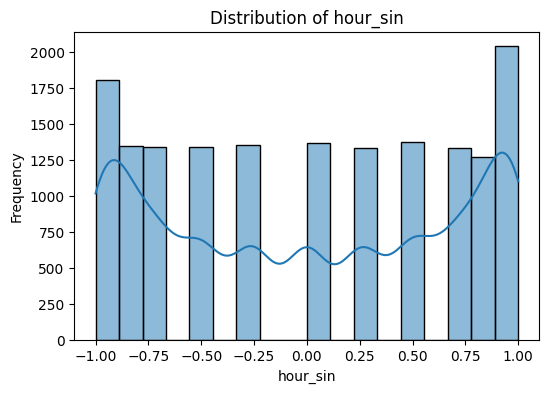

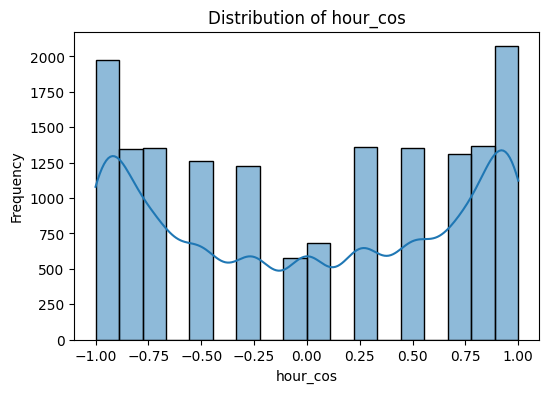

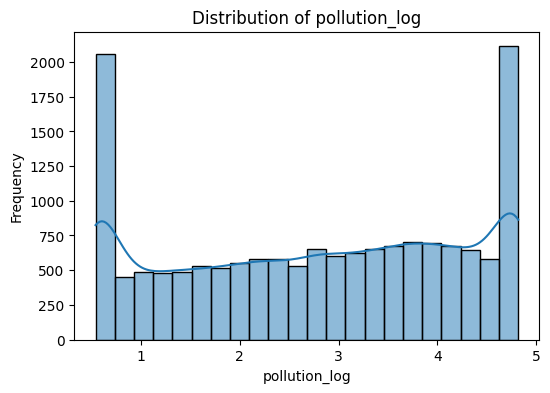

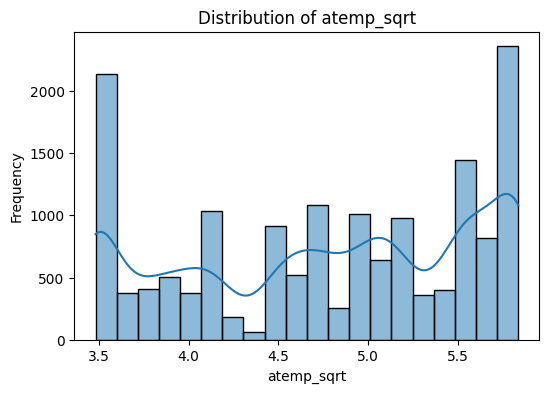

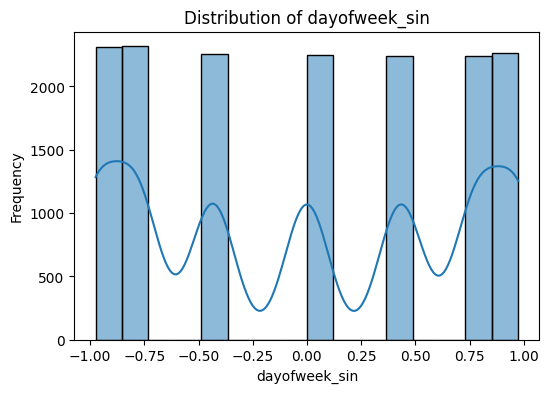

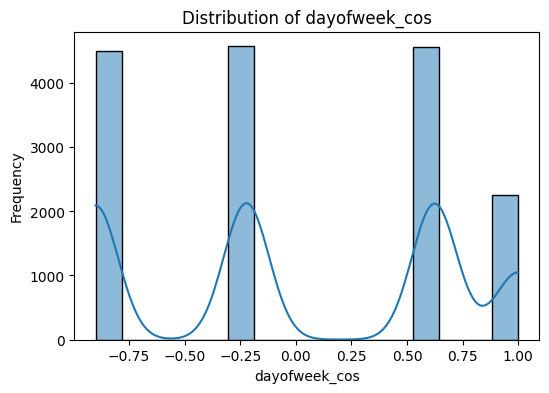

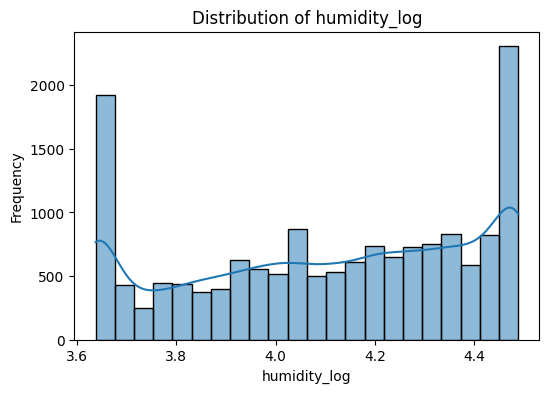

In [175]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of transformed features
transformed_features = ['hour_sin', 'hour_cos', 'pollution_log', 'atemp_sqrt', 'dayofweek_sin', 'dayofweek_cos', 'humidity_log']

# Plotting distributions of transformed features
for feature in transformed_features:
    plt.figure(figsize=(6, 4))
    sns.histplot(cleaned_df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()


In [176]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define features and target variable
X = cleaned_df.drop(['count','datetime'], axis=1)  # Include all original and transformed features
y = cleaned_df['count']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

best_rf = RandomForestRegressor( max_features= 'auto', min_samples_leaf= 1, min_samples_split= 2, n_estimators= 300, random_state=42)
best_rf.fit(X_train, y_train)
y_pred_best = best_rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")



Mean Squared Error: 762.7880159005038
Mean Absolute Error: 14.702748740554155
R^2 Score: 0.9703772627647843


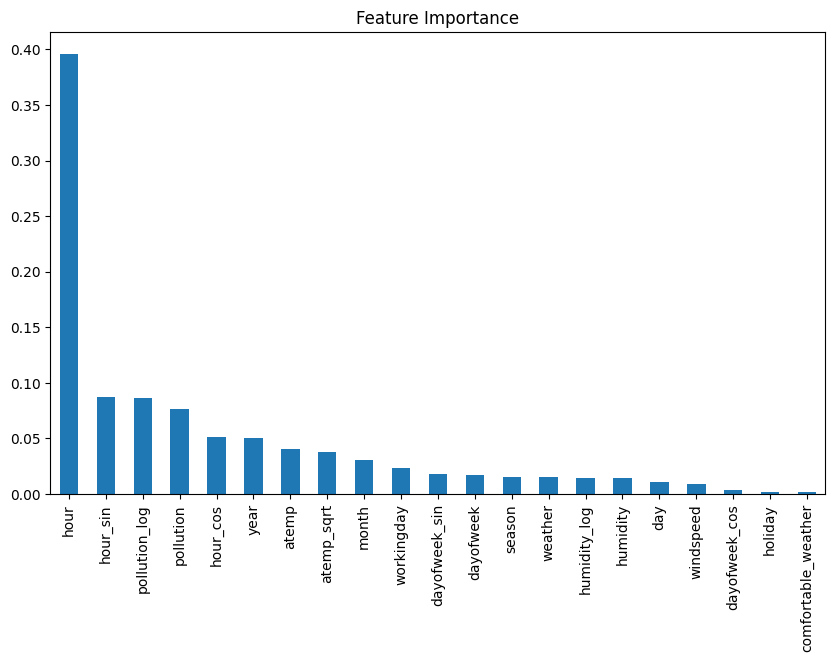

In [177]:
importances = best_rf.feature_importances_
feature_names = X.columns
forest_importances = pd.Series(importances, index=feature_names)

# Plot
plt.figure(figsize=(10, 6))
forest_importances.sort_values(ascending=False).plot(kind='bar')
plt.title('Feature Importance')
plt.show()



### AdaBoost

In [180]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Initialize AdaBoost Regressor
ada_reg = AdaBoostRegressor(random_state=42)

# Train the model
ada_reg.fit(X_train, y_train)

# Make predictions
y_pred_ada = ada_reg.predict(X_test)

# Evaluate the model
mse_ada = mean_squared_error(y_test, y_pred_ada)
mae_ada = mean_absolute_error(y_test, y_pred_ada)
r2_ada = r2_score(y_test, y_pred_ada)

print(f"AdaBoost - Mean Squared Error: {mse_ada}")
print(f"AdaBoost - Mean Absolute Error: {mae_ada}")
print(f"AdaBoost - R^2 Score: {r2_ada}")


AdaBoost - Mean Squared Error: 10314.294932527264
AdaBoost - Mean Absolute Error: 83.84893516270678
AdaBoost - R^2 Score: 0.5994461866419447


In [182]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor


# Define the parameter grid
# param_grid = {
#     'n_estimators': [300,500,700],
#     'learning_rate': [0.1,0.5,1.0],
#     'loss':['linear'],
#     'base_estimator__max_depth': [7,10]
# }

# Create AdaBoost with a DecisionTreeRegressor as its base estimator
# ada_reg = AdaBoostRegressor(base_estimator=DecisionTreeRegressor())

# # Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=ada_reg, param_grid=param_grid,
#                            cv=5, n_jobs=-1, verbose=2)

best_ada = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=10, random_state=42),
                                 learning_rate=0.1, loss='linear', n_estimators=500, random_state=42)
best_ada.fit(X_train, y_train)
# Fit GridSearchCV
# grid_search.fit(X_train, y_train)

# Best parameters and best score
# print("Best parameters:", grid_search.best_params_)
# print("Best score (negative MSE):", grid_search.best_score_)

# Evaluate on the test set
# best_ada = grid_search.best_estimator_
y_pred_best = best_ada.predict(X_test)
mse = mean_squared_error(y_test, y_pred_best)
mae = mean_absolute_error(y_test, y_pred_best)
r2 = r2_score(y_test, y_pred_best)

mse_train = mean_squared_error(y_train, best_ada.predict(X_train))
print("MSE on Training Set:", mse_train)
print(f"Optimized AdaBoost - Mean Squared Error: {mse}")
print(f"Optimized AdaBoost - Mean Absolute Error: {mae}")
print(f"Optimized AdaBoost - R^2 Score: {r2}")
# print("Best parameters found by GridSearchCV:", grid_search.best_params_)

MSE on Training Set: 405.0650678996298
Optimized AdaBoost - Mean Squared Error: 761.3566369757627
Optimized AdaBoost - Mean Absolute Error: 18.55846113557306
Optimized AdaBoost - R^2 Score: 0.9704328501113181


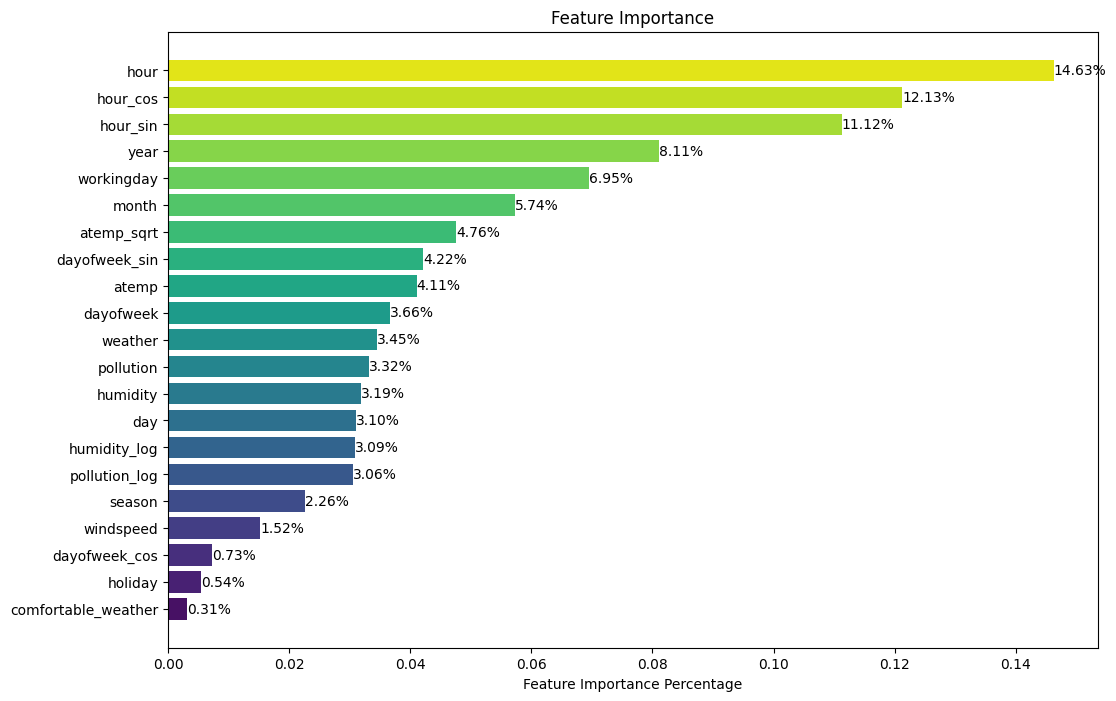

In [183]:
importances = best_ada.feature_importances_
feature_names = X.columns

# Sort the feature importances and corresponding feature names
sorted_indices = np.argsort(importances)
sorted_feature_importances = importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Set the figure size
plt.rcParams["figure.figsize"] = (12, 8)

# Create horizontal bar plot
bars = plt.barh(range(len(sorted_feature_importances)), sorted_feature_importances, align='center', color=sns.color_palette("viridis", len(sorted_feature_importances)))

# Adding percentage labels to each bar
for bar, importance in zip(bars, sorted_feature_importances):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{importance*100:.2f}%', ha='left', va='center')

plt.yticks(range(len(sorted_feature_importances)), sorted_feature_names)
plt.title('Feature Importance')
plt.xlabel('Feature Importance Percentage')
plt.show()

### XGBoost

In [195]:


# param_grid = {
#     'max_depth': [3, 5,7],
#     'n_estimators': [500, 1000],
#     'alpha': [0.05,0.1, 0.5],
#     'lambda': [1, 2],
#     'learning_rate':[0.1,0.5,1.0]
# }

# grid_search = GridSearchCV(XGBRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
# grid_search.fit(X_train, y_train)
# best_params = grid_search.best_params_

# best_XGBoost_model = XGBRegressor(**grid_search.best_params_, random_state=42)


best_XGBoost_model = XGBRegressor(alpha=0.1, reg_lambda=1,learning_rate=0.1, max_depth=7, n_estimators=1000, random_state=42)
best_XGBoost_model.fit(X_train, y_train)

y_pred_XGBoost = best_XGBoost_model.predict(X_test)

# Evaluate the model
mse_XGBoost = mean_squared_error(y_test, y_pred_XGBoost)
mae_XGBoost = mean_absolute_error(y_test, y_pred_XGBoost)
r2_XGBoost = r2_score(y_test, y_pred_XGBoost)


print("Mean Squared Error on Test Set:", mse_XGBoost)
print(f"Mean Absolute Error: {mae_XGBoost}")
print("R-Squared on Test Set:", r2_XGBoost)
print("Best parameters found by GridSearchCV:", grid_search.best_params_)
# Mean Squared Error on Test Set: 350.2349637869833
# Mean Absolute Error: 6.537168797276801
# R-Squared on Test Set: 0.9863986873330737
# Best parameters found by GridSearchCV: {'alpha': 0.1, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 1000}


Mean Squared Error on Test Set: 350.2349637869833
Mean Absolute Error: 6.537168797276801
R-Squared on Test Set: 0.9863986873330737
Best parameters found by GridSearchCV: {'base_estimator__max_depth': 10, 'learning_rate': 0.1, 'loss': 'linear', 'n_estimators': 500}


Lets now try to remove some unsginificant features from each model and retrain them to see if we get some improvment.

In [196]:
def get_important_features(model_names, feature_names, feature_importances, threshold):
    """
    Identify important features for each model based on a given threshold and report the number of features dropped.

    :param model_names: List of model names (e.g., ['Random Forest', 'AdaBoost', 'XGBoost'])
    :param feature_names: List of feature names
    :param feature_importances: List of arrays with feature importances for each model
    :param threshold: Threshold for determining feature importance
    :return: Dictionary with model names as keys and lists of important features as values
    """
    important_features_dict = {}
    dropped_features_count = {}

    for model_name, importances in zip(model_names, feature_importances):
        important_features = [feature_names[i] for i in range(len(importances)) if importances[i] > threshold]
        important_features_dict[model_name] = important_features
        dropped_features_count[model_name] = len(feature_names) - len(important_features)

    return important_features_dict, dropped_features_count

model_names = ['Random Forest', 'AdaBoost', 'XGBoost']
feature_names = X_train.columns.tolist()
rf_feature_importances = best_rf.feature_importances_
ada_feature_importances = best_ada.feature_importances_
xgb_feature_importances = best_XGBoost_model.feature_importances_
feature_importances = [rf_feature_importances, ada_feature_importances, xgb_feature_importances]
threshold = 0.005

important_features, dropped_features_count = get_important_features(model_names, feature_names, feature_importances, threshold)

for model_name in model_names:
    print(f"Important features for {model_name}: {important_features[model_name]}")
    print(f"Number of features dropped for {model_name}: {dropped_features_count[model_name]}")


Important features for Random Forest: ['year', 'month', 'day', 'hour', 'dayofweek', 'season', 'workingday', 'weather', 'atemp', 'humidity', 'windspeed', 'pollution', 'hour_sin', 'hour_cos', 'pollution_log', 'atemp_sqrt', 'dayofweek_sin', 'humidity_log']
Number of features dropped for Random Forest: 3
Important features for AdaBoost: ['year', 'month', 'day', 'hour', 'dayofweek', 'season', 'holiday', 'workingday', 'weather', 'atemp', 'humidity', 'windspeed', 'pollution', 'hour_sin', 'hour_cos', 'pollution_log', 'atemp_sqrt', 'dayofweek_sin', 'dayofweek_cos', 'humidity_log']
Number of features dropped for AdaBoost: 1
Important features for XGBoost: ['year', 'month', 'hour', 'dayofweek', 'holiday', 'workingday', 'weather', 'atemp', 'humidity', 'pollution', 'comfortable_weather', 'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos']
Number of features dropped for XGBoost: 6


In [197]:
def train_evaluate_rf(features):
    X_train_rf = X_train[features]
    X_test_rf = X_test[features]

    best_rf = RandomForestRegressor(max_features='auto', min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=42)
    best_rf.fit(X_train_rf, y_train)
    y_pred_rf = best_rf.predict(X_test_rf)

    mse_rf = mean_squared_error(y_test, y_pred_rf)
    mae_rf = mean_absolute_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)

    return mse_rf, mae_rf, r2_rf

def train_evaluate_ada(features):
    X_train_ada = X_train[features]
    X_test_ada = X_test[features]

    best_ada = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=10, random_state=42),
                                 learning_rate=0.1, loss='linear', n_estimators=500, random_state=42)
    best_ada.fit(X_train_ada, y_train)
    y_pred_ada = best_ada.predict(X_test_ada)
    mse_ada = mean_squared_error(y_test, y_pred_ada)
    mae_ada = mean_absolute_error(y_test, y_pred_ada)
    r2_ada = r2_score(y_test, y_pred_ada)

    return mse_ada, mae_ada, r2_ada

def train_evaluate_xgb(features):
    X_train_xgb = X_train[features]
    X_test_xgb = X_test[features]

    best_XGBoost_model = XGBRegressor(alpha=0.1, reg_lambda=1,learning_rate=0.1, max_depth=7, n_estimators=1000, random_state=42)
    best_XGBoost_model.fit(X_train_xgb, y_train)
    y_pred_xgb = best_XGBoost_model.predict(X_test_xgb)

    mse_xgb = mean_squared_error(y_test, y_pred_xgb)
    mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
    r2_xgb = r2_score(y_test, y_pred_xgb)

    return mse_xgb, mae_xgb, r2_xgb


In [198]:
# rf_features = important_features['Random Forest']
# ada_features = important_features['AdaBoost']
# xgb_features = important_features['XGBoost']

# # Train and evaluate each model
# mse_rf, mae_rf, r2_rf = train_evaluate_rf(rf_features)
# mse_ada, mae_ada, r2_ada = train_evaluate_ada(ada_features)
# mse_xgb, mae_xgb, r2_xgb = train_evaluate_xgb(xgb_features)

# # Print the results
# print(f"Random Forest - MSE: {mse_rf}, MAE: {mae_rf}, R2: {r2_rf}")
# print(f"AdaBoost - MSE: {mse_ada}, MAE: {mae_ada}, R2: {r2_ada}")
# print(f"XGBoost - MSE: {mse_xgb}, MAE: {mae_xgb}, R2: {r2_xgb}")

# Random Forest - MSE: 676.4591718024069, MAE: 14.10063182199832, R2: 0.9737298281056528
# AdaBoost - MSE: 443.9798298414807, MAE: 7.221827268341868, R2: 0.9827581220955555
# XGBoost - MSE: 440.733368819594, MAE: 8.746266835667099, R2: 0.9828841978332323


We tried to cut the unsignificant features by different thresholds and it did a bit of increase of the error for each modell so we will just show how we did it and wont use it

## Now lets preprocces on the test set

In [188]:
def preprocess_data(df):
    # Define comfortable weather criteria
    temp_comfortable_low, temp_comfortable_high = df['temp'].quantile([0.25, 0.75])
    humidity_comfortable = df['humidity'].quantile(0.60)
    windspeed_comfortable = df['windspeed'].quantile(0.60)
    sunlight_comfortable = df['sunlight'].quantile(0.40)

    # Create 'comfortable_weather' feature
    df['comfortable_weather'] = ((df['weather'] == 1) &
                                 (df['temp'] >= temp_comfortable_low) &
                                 (df['temp'] <= temp_comfortable_high) &
                                 (df['humidity'] <= humidity_comfortable) &
                                 (df['windspeed'] <= windspeed_comfortable) &
                                 (df['sunlight'] >= sunlight_comfortable)).astype(int)

    # Create time-related features
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['dayofweek'] = df['datetime'].dt.dayofweek

    #overproduce on the test
    # Hour - Sine and Cosine Transformation
    df['hour_sin'] = np.sin(df['hour'] * (2. * np.pi / 24))
    df['hour_cos'] = np.cos(df['hour'] * (2. * np.pi / 24))

    # Pollution - Logarithmic Transformation
    df['pollution_log'] = np.log(df['pollution'] + 1)  # Adding 1 to avoid log(0)

    # Atemp - Square Root Transformation (as an example)
    df['atemp_sqrt'] = np.sqrt(df['atemp'])

    # Day of the Week - Sine and Cosine Transformation
    df['dayofweek_sin'] = np.sin(df['dayofweek'] * (2. * np.pi / 7))
    df['dayofweek_cos'] = np.cos(df['dayofweek'] * (2. * np.pi / 7))

    # Humidity - Logarithmic Transformation (if skewed)
    df['humidity_log'] = np.log(df['humidity'] + 1)
    # Drop unnecessary columns
    df = df.drop(['temp', 'sunlight', 'traffic', 'datetime'], axis=1)

    # Remove outliers for 'count' within each 'weather' and 'season' category
    cleaned_df = pd.DataFrame()
    for category in df['weather'].unique():
        category_df = df[df['weather'] == category]
        category_df_cleaned = remove_outliers(category_df, 'count')
        cleaned_df = pd.concat([cleaned_df, category_df_cleaned])

    for category in df['season'].unique():
        category_df = df[df['season'] == category]
        category_df_cleaned = remove_outliers(category_df, 'count')
        cleaned_df = pd.concat([cleaned_df, category_df_cleaned])

    # Winsorize specific columns
    columns = ['atemp', 'humidity', 'windspeed', 'pollution']
    for column in columns:
        cleaned_df = winsorize_data(cleaned_df, column, lower_percentile=0.10, upper_percentile=0.9)

    return cleaned_df


## Model Evaluation

### We chose xgboost model since it gave us the best score

In [201]:
# Cross-validation for the XGBoost model
cv_scores = cross_val_score(best_XGBoost_model, X, y, cv=5, scoring='neg_mean_squared_error')

# Calculate average MSE and convert to positive value
cv_mse = -np.mean(cv_scores)


In [202]:

test_df = pd.read_csv(test_url)

# Preprocess the test set
preprocessed_test_df = preprocess_data(test_df)

# Separate features and target variable if 'count' is in the test set
if 'count' in preprocessed_test_df.columns:
    X_test = preprocessed_test_df.drop('count', axis=1)
    y_test = preprocessed_test_df['count']
else:
    X_test = preprocessed_test_df


X_test = X_test[X_train.columns]

y_pred_test_external = best_XGBoost_model.predict(X_test)

# Calculate RMSE on the external test set
rmse_test_external = np.sqrt(mean_squared_error(y_test, y_pred_test_external))
print("RMSE on External Test Set:", rmse_test_external)


RMSE on External Test Set: 35.942074877914415


In [208]:
def evaluate_models(models, model_names, hyperparams, features_dropped, new_features, hardware_used):
    results = []

    for i, model in enumerate(models):
        start_time = time.time()

        # Train and predict with the model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calculate metrics
        rmse = sqrt(mean_squared_error(y_test, y_pred))
        runtime = time.time() - start_time

        # Get top 3 features if applicable (for tree-based models)
        if hasattr(model, 'feature_importances_'):
            top_features = sorted(zip(X_train.columns, model.feature_importances_), key=lambda x: x[1], reverse=True)[:3]
            top_features = [feature[0] for feature in top_features]
        else:
            top_features = ['N/A']

        # Append results
        results.append([model_names[i], rmse, hyperparams[i], features_dropped[i], new_features[i], runtime, hardware_used[i], top_features])

    # Create a DataFrame
    results_df = pd.DataFrame(results, columns=['Model', 'Score (RMSE)', 'Hyperparams used', 'Features dropped', 'New features created', 'Runtime training + inference (seconds)', 'Hardware used', 'Explainability (top 3 features)'])
    return results_df
models = [best_rf,best_ada, best_XGBoost_model]
model_names = ['RandomForest','Adaboost','XGboost']
hyperparams = ["(max_features='auto', min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=42)","(base_estimator=DecisionTreeRegressor(max_depth=10, random_state=42),learning_rate=0.1, loss=linear, n_estimators=500, random_state=42)", "(alpha=0.1, reg_lambda=1,learning_rate=0.1, max_depth=7, n_estimators=1000, random_state=42)"]
features_dropped = [['temp','sunlight','traffic','datetime'],['temp','sunlight','traffic','datetime'],['temp','sunlight','traffic','datetime']]
new_features = [['comfortable_weather', 'year', 'month', 'day', 'hour', 'dayofweek', 'hour_sin', 'hour_cos', 'pollution_log', 'atemp_sqrt', 'dayofweek_sin', 'dayofweek_cos', 'humidity_log'], ['comfortable_weather', 'year', 'month', 'day', 'hour', 'dayofweek', 'hour_sin', 'hour_cos', 'pollution_log', 'atemp_sqrt', 'dayofweek_sin', 'dayofweek_cos', 'humidity_log'],['comfortable_weather', 'year', 'month', 'day', 'hour', 'dayofweek', 'hour_sin', 'hour_cos', 'pollution_log', 'atemp_sqrt', 'dayofweek_sin', 'dayofweek_cos', 'humidity_log']]
hardware_used = ['CPU', 'CPU','CPU']

# Evaluate models
model_results = evaluate_models(models, model_names, hyperparams, features_dropped, new_features, hardware_used)
print(model_results)
df = pd.DataFrame(model_results)
df.to_csv(os.path.join(os.getcwd(), 'exercise1.csv'))

          Model  Score (RMSE)  \
0  RandomForest     41.509202   
1      Adaboost     39.057945   
2       XGboost     35.942075   

                                    Hyperparams used  \
0  (max_features='auto', min_samples_leaf=1, min_...   
1  (base_estimator=DecisionTreeRegressor(max_dept...   
2  (alpha=0.1, reg_lambda=1,learning_rate=0.1, ma...   

                      Features dropped  \
0  [temp, sunlight, traffic, datetime]   
1  [temp, sunlight, traffic, datetime]   
2  [temp, sunlight, traffic, datetime]   

                                New features created  \
0  [comfortable_weather, year, month, day, hour, ...   
1  [comfortable_weather, year, month, day, hour, ...   
2  [comfortable_weather, year, month, day, hour, ...   

   Runtime training + inference (seconds) Hardware used  \
0                               20.500768           CPU   
1                               28.152191           CPU   
2                                2.865061           CPU   

   Explaina